In [1]:
# --- Step 1: Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

sns.set(style="whitegrid")

In [2]:
# --- Step 2: Load dataset ---
df = pd.read_csv("C:/Users/DELL/Desktop/MSc/1st Sem/AML/Loan_Default - Copy.csv")
print("Raw shape:", df.shape)

Raw shape: (49999, 34)


In [3]:
# Drop ID if exists
if "ID" in df.columns:
    df = df.drop(columns=["ID"])

Missing values:
 Upfront_charges         13287
Interest_rate_spread    12281
rate_of_interest        12209
dtir1                    8072
property_value           5104
dtype: int64


C:\Users\DELL\AppData\Local\Temp\ipykernel_16576\2273430787.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Status", data=df, palette="coolwarm")


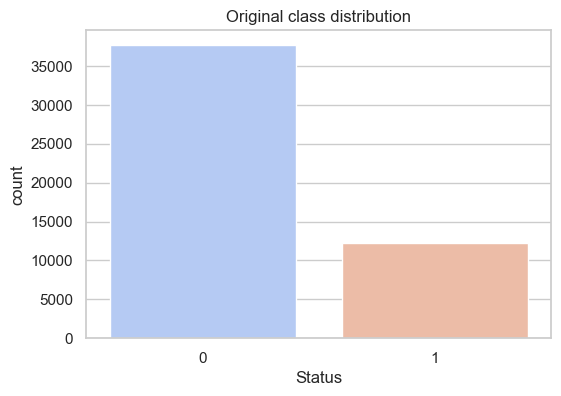

In [4]:

# --- Step 3: Explore data ---
print("Missing values:\n", df.isnull().sum().sort_values(ascending=False).head())

plt.figure(figsize=(6,4))
sns.countplot(x="Status", data=df, palette="coolwarm")
plt.title("Original class distribution")
plt.show()

In [5]:
# --- Step 4: Train/Test split ---
X_raw = df.drop(columns=["Status"], errors="ignore")
y = df["Status"]

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y, test_size=0.2, stratify=y, random_state=42
)

In [6]:
# --- Step 5: Preprocessing ---
num_cols = X_train_raw.select_dtypes(include=["int64","float64"]).columns.tolist()
cat_cols = X_train_raw.select_dtypes(include=["object","category"]).columns.tolist()

# Numeric imputer
num_imputer = SimpleImputer(strategy="median")
X_train_num = pd.DataFrame(num_imputer.fit_transform(X_train_raw[num_cols]), columns=num_cols, index=X_train_raw.index)
X_test_num  = pd.DataFrame(num_imputer.transform(X_test_raw[num_cols]), columns=num_cols, index=X_test_raw.index)

# Categorical imputer
cat_imputer = SimpleImputer(strategy="most_frequent")
if cat_cols:
    X_train_cat_imp = pd.DataFrame(cat_imputer.fit_transform(X_train_raw[cat_cols]), columns=cat_cols, index=X_train_raw.index)
    X_test_cat_imp  = pd.DataFrame(cat_imputer.transform(X_test_raw[cat_cols]), columns=cat_cols, index=X_test_raw.index)
else:
    X_train_cat_imp = pd.DataFrame(index=X_train_raw.index)
    X_test_cat_imp  = pd.DataFrame(index=X_test_raw.index)

In [7]:
# OneHotEncoder
if cat_cols:
    encoder = OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore")
    enc_train = encoder.fit_transform(X_train_cat_imp)
    enc_test  = encoder.transform(X_test_cat_imp)
    enc_cols = encoder.get_feature_names_out(cat_cols)
    X_train_cat = pd.DataFrame(enc_train, columns=enc_cols, index=X_train_raw.index)
    X_test_cat  = pd.DataFrame(enc_test, columns=enc_cols, index=X_test_raw.index)
else:
    X_train_cat = pd.DataFrame(index=X_train_raw.index)
    X_test_cat  = pd.DataFrame(index=X_test_raw.index)

# Combine num + cat
X_train_pre = pd.concat([X_train_num, X_train_cat], axis=1)
X_test_pre  = pd.concat([X_test_num,  X_test_cat],  axis=1)

After SMOTE:
 Status
0    30174
1    30174
Name: count, dtype: int64


C:\Users\DELL\AppData\Local\Temp\ipykernel_16576\3546696855.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train_res, palette="viridis")


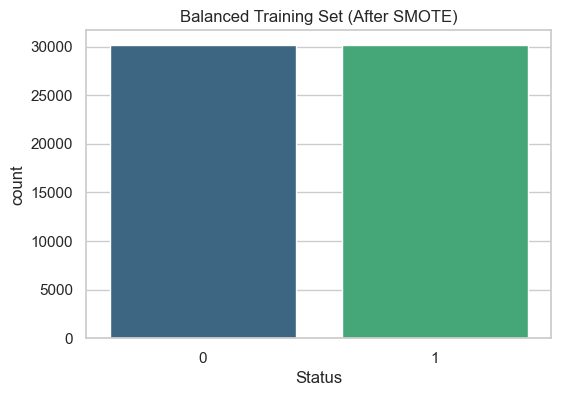

In [8]:
# --- Step 6: SMOTE ---
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_pre, y_train)

print("After SMOTE:\n", pd.Series(y_train_res).value_counts())

plt.figure(figsize=(6,4))
sns.countplot(x=y_train_res, palette="viridis")
plt.title("Balanced Training Set (After SMOTE)")
plt.show()

In [9]:
# --- Step 7: Baseline AdaBoost ---
base_ada = AdaBoostClassifier(random_state=42)
base_ada.fit(X_train_res, y_train_res)

y_pred_base = base_ada.predict(X_test_pre)
y_proba_base = base_ada.predict_proba(X_test_pre)[:,1]

print("\nBaseline AdaBoost Results:")
print(confusion_matrix(y_test, y_pred_base))
print(classification_report(y_test, y_pred_base))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_base))


Baseline AdaBoost Results:
[[7544    0]
 [   0 2456]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7544
           1       1.00      1.00      1.00      2456

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000

ROC-AUC: 1.0


In [11]:
# --- Step 8: Hyperparameter tuning ---
param_dist = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.05, 0.1, 0.5, 1.0],
    "estimator": [DecisionTreeClassifier(max_depth=d) for d in [1, 2, 3]]
}

rs = RandomizedSearchCV(
    AdaBoostClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    scoring="f1",
    n_jobs=-1,
    verbose=1,
    random_state=42
)

rs.fit(X_train_res, y_train_res)
print("\nBest params:", rs.best_params_)

best_ada = rs.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best params: {'n_estimators': 100, 'learning_rate': 0.5, 'estimator': DecisionTreeClassifier(max_depth=2)}


In [12]:
# --- Step 9: Final Evaluation ---
y_pred = best_ada.predict(X_test_pre)
y_proba = best_ada.predict_proba(X_test_pre)[:,1]

print("\nTuned AdaBoost Results:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))


Tuned AdaBoost Results:
[[7544    0]
 [   0 2456]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7544
           1       1.00      1.00      1.00      2456

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000

ROC-AUC: 1.0


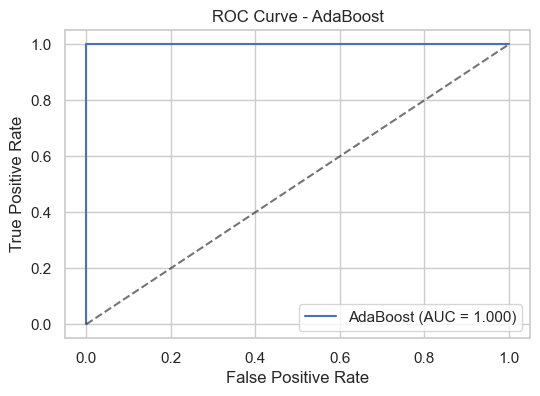

In [13]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'AdaBoost (AUC = {roc_auc_score(y_test, y_proba):.3f})')
plt.plot([0,1],[0,1],'k--', alpha=0.6)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - AdaBoost")
plt.legend()
plt.show()

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.tree import DecisionTreeClassifier

# --- Shuffled target test ---
def shuffled_target_test(model, X_train, y_train, X_test, y_test):
    """Train with shuffled target to test for leakage."""
    y_train_shuffled = np.random.permutation(y_train)
    model.fit(X_train, y_train_shuffled)
    acc = model.score(X_test, y_test)
    print("Accuracy with shuffled target:", acc)
    return acc

# --- Shallow tree test ---
def shallow_tree_test(X_train, y_train, X_test, y_test):
    """Fit a weak decision tree to test dataset complexity / leakage."""
    dt_test = DecisionTreeClassifier(random_state=42, max_depth=3)
    dt_test.fit(X_train, y_train)
    acc = dt_test.score(X_test, y_test)
    print("Shallow tree test accuracy:", acc)
    return acc

# --- Cross-validation test ---
def cross_validation_test(model, X, y, cv=5):
    """Cross-validation scores."""
    scores = cross_val_score(model, X, y, cv=cv, scoring="accuracy", n_jobs=-1)
    print("Cross-validation scores:", scores)
    print("Mean accuracy:", scores.mean())
    return scores

# --- Learning curve plot ---
def plot_learning_curve(model, X, y, cv=5, title="Learning Curve"):
    """Plot learning curves for train and validation sets."""
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=cv, scoring="accuracy", n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)
    )
    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)

    plt.figure(figsize=(8,5))
    plt.plot(train_sizes, train_mean, label="Train score", marker="o")
    plt.plot(train_sizes, val_mean, label="Validation score", marker="o")
    plt.title(title)
    plt.xlabel("Training set size")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()


Accuracy with shuffled target: 0.5079
Shallow tree test accuracy: 1.0
Cross-validation scores: [0.9998343 0.9998343 0.9998343 1.        1.       ]
Mean accuracy: 0.99990057995029


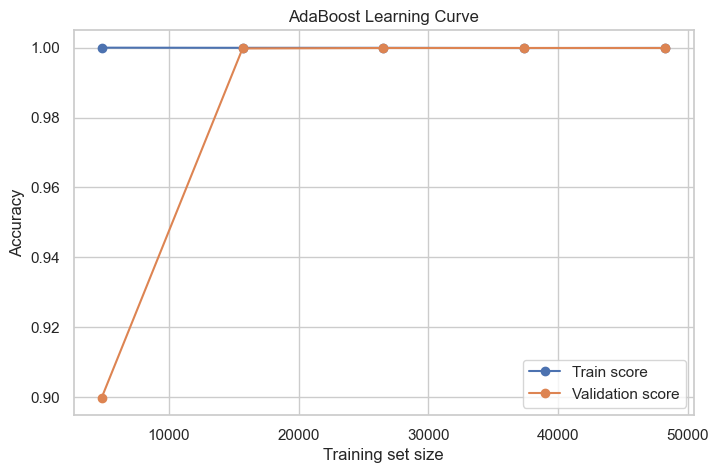

In [17]:
# --- AdaBoost Sanity Checks ---
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(random_state=42)

# 1. Shuffled target test
shuffled_target_test(ada, X_train_res, y_train_res, X_test_pre, y_test)

# 2. Shallow tree test
shallow_tree_test(X_train_res, y_train_res, X_test_pre, y_test)

# 3. Cross-validation
cross_validation_test(ada, X_train_res, y_train_res)

# 4. Learning curve
plot_learning_curve(ada, X_train_res, y_train_res, title="AdaBoost Learning Curve")